<a href="https://colab.research.google.com/github/Kim-JH-01/AI_lab_Juhun/blob/main/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# 유튜브 다운로더 및 오디오 처리 라이브러리 설치
!pip install -q yt-dlp

# FFmpeg 설치 (torchaudio가 오디오 포맷을 다루기 위해 필요)
!apt-get -qq update && apt-get -qq install -y ffmpeg

# 필수 라이브러리 임포트
import torch
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio

print("✅ 환경 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 환경 설정 완료!


In [16]:
# 텍스트로 변환할 유튜브 영상 URL
youtube_url = "https://www.youtube.com/shorts/HAHHQO3h6Ag" # <--- 변환할 영상 주소로 변경

# yt-dlp로 오디오만 m4a 포맷으로 다운로드
output_filename = "youtube_audio.m4a"
!yt-dlp -x --audio-format m4a -o "{output_filename}" {youtube_url}

downloaded_filepath = Path(output_filename)
if downloaded_filepath.exists():
    print(f"✅ 오디오 추출 완료: {downloaded_filepath.name}")
    display(Audio(str(downloaded_filepath))) # 원본 소리 들어보기
else:
    print(f"❌ 오디오 추출 실패.")

[youtube] Extracting URL: https://www.youtube.com/shorts/HAHHQO3h6Ag
[youtube] HAHHQO3h6Ag: Downloading webpage
[youtube] HAHHQO3h6Ag: Downloading tv client config
[youtube] HAHHQO3h6Ag: Downloading tv player API JSON
[youtube] HAHHQO3h6Ag: Downloading web safari player API JSON
[youtube] HAHHQO3h6Ag: Downloading m3u8 information
[info] HAHHQO3h6Ag: Downloading 1 format(s): 251
[download] Sleeping 3.00 seconds as required by the site...
[download] Destination: youtube_audio.webm
[download] 100% of  257.49KiB in 00:00:00 at 460.32KiB/s
[ExtractAudio] Destination: youtube_audio.m4a
Deleting original file youtube_audio.webm (pass -k to keep)
✅ 오디오 추출 완료: youtube_audio.m4a


In [17]:
# Wav2Vec2 모델 번들 로드 (정보 확인용)
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

# 오디오 파일 불러오기
waveform, sample_rate = torchaudio.load(downloaded_filepath)

# 샘플링 레이트가 모델 요구사항과 다르면 리샘플링
if sample_rate != bundle.sample_rate:
    print(f"리샘플링 수행: {sample_rate} Hz -> {bundle.sample_rate} Hz")
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

print("✅ 데이터 로딩 및 전처리 완료!")

리샘플링 수행: 48000 Hz -> 16000 Hz
✅ 데이터 로딩 및 전처리 완료!



--- 시각화 결과 ---


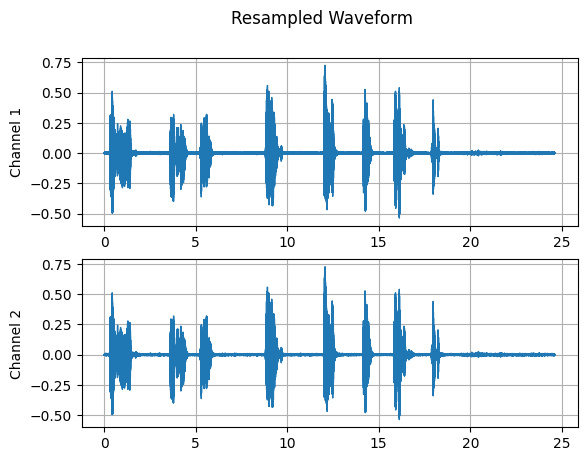

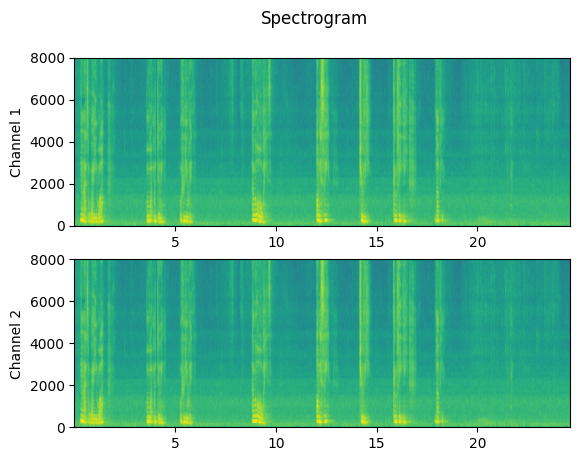

In [18]:
# --- 시각화에 필요한 라이브러리 ---
import matplotlib.pyplot as plt
import torch

# --- 시각화 함수 정의 (Feature Extraction 튜토리얼에서 가져옴) ---

def plot_waveform(waveform, sr, title="Waveform"):
    """오디오 파형(Waveform)을 그리는 함수"""
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show()

def plot_specgram(waveform, sr, title="Spectrogram"):
    """스펙트로그램(Spectrogram)을 그리는 함수"""
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sr)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show()

# --- 시각화 실행 ---
# 3단계에서 리샘플링된 waveform과 모델의 샘플링 레이트(bundle.sample_rate)를 사용합니다.
print("\n--- 시각화 결과 ---")
plot_waveform(waveform, bundle.sample_rate, title="Resampled Waveform")
plot_specgram(waveform, bundle.sample_rate, title="Spectrogram")

In [19]:
# --- GPU 설정 및 모델/데이터 이동 ---
# Colab에서는 보통 GPU 사용이 가능합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 이전에 정의된 bundle과 waveform 변수를 사용합니다.
model = bundle.get_model().to(device)
waveform = waveform.to(device)

# --- 모델을 통해 로짓(emission) 추출 ---
# emission은 각 시간 프레임별로 어떤 글자일 확률이 높은지에 대한 점수표입니다.
print("\n모델을 통해 텍스트 예측을 시작합니다...")
with torch.inference_mode():
    emission, _ = model(waveform)
print("✅ 예측 완료!")

# --- Greedy 디코더로 텍스트 변환 ---

# GreedyCTCDecoder 클래스 전체 정의
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """
        주어진 로짓(emission) 시퀀스로부터 가장 가능성 있는 경로의 문자열을 찾습니다.

        Args:
          emission (Tensor): 로짓 텐서. Shape: `[num_seq, num_label]`

        Returns:
          str: 최종 변환된 텍스트
        """
        # 1. 각 시간 프레임에서 가장 높은 점수를 가진 글자의 인덱스를 찾습니다.
        indices = torch.argmax(emission, dim=-1)

        # 2. 연속으로 반복되는 인덱스를 하나로 합칩니다. (예: [1, 1, 1, 2, 2] -> [1, 2])
        indices = torch.unique_consecutive(indices, dim=-1)

        # 3. 'blank' 토큰(인덱스 0)을 제거합니다.
        indices = [i for i in indices if i != self.blank]

        # 4. 최종 인덱스 목록을 실제 글자로 변환하여 하나의 문자열로 합칩니다.
        return "".join([self.labels[i] for i in indices])


# 디코더 객체 생성
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
# 디코딩 실행
transcript = decoder(emission[0])


# --- 서식 변환 함수 정의 ---
def format_transcript(raw_transcript):
  """
  Wav2Vec2의 원본 출력 텍스트를 보기 좋은 문장으로 변환합니다.
  """
  sentence = raw_transcript.replace('|', ' ')
  sentence = sentence.capitalize()
  sentence = sentence.strip()
  return sentence

# --- 최종 변환 결과 출력 ---
print("\n--- 📝 최종 변환 결과 ---")

# 원본 출력과 변환된 출력을 함께 보여줍니다.
print(f"원본: {transcript}")
print(f"변환: {format_transcript(transcript)}")

Using device: cuda

모델을 통해 텍스트 예측을 시작합니다...
✅ 예측 완료!

--- 📝 최종 변환 결과 ---
원본: NO|MATTER|WHERE|YOU|ARE|OR|WHAT|YOU|ARE|DOING|WHO|YOU|WIT|I|WILL|ALWAYS|HONESTLY|TRULY|COMPLETELY|LOVE|YOU|
변환: No matter where you are or what you are doing who you wit i will always honestly truly completely love you
